<a href="https://colab.research.google.com/github/Raian-Rahman/Data-Mining-Implementation/blob/main/FP_Growth_Impelementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import time
from itertools import chain, combinations


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data Mining Assignment/shortened_dataset.csv')
df = df[:500]
df.head()

,Unnamed: 0,order_id,products
0,0,1,"['citrus fruit', 'semi-finished bread', 'marga..."
1,1,2,"['tropical fruit', 'yogurt', 'coffee']"
2,2,3,['whole milk']
3,3,4,"['pip fruit', 'yogurt', 'cream cheese', 'meat ..."
4,4,5,"['other vegetables', 'whole milk', 'condensed ..."


In [4]:
def preprocess_data(df):
    item_LUT = dict()
    item_index = 1
    transaction = dict()
    for index in df.index:
        product_id = df['products'][index]
        product_id = product_id.strip('][').split(', ')
        # print(product_id)
        
        item_list = list()
        for item in product_id: 
            if item_LUT.get(item,-100) == -100:
                #its not on the list
                item_LUT[item] = item_index
                item_index+=1

            item_list.append(item_LUT[item])
        transaction[item_index] = item_list
        item_index+=1

    processed_transaction = []
    for key in transaction.keys():
        row = dict()
        row['order_id'] = key
        row['products'] = transaction[key]
        processed_transaction.append(row)

    all_transaction = dict()
    for item in processed_transaction:
        # print(item['products'])
        itemss = set(item['products'])
        all_transaction[item['order_id']] = itemss

    all_transaction
    return all_transaction

### Coding FP-Growth

In [5]:
## all Possible Combination
def generate_subsets(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1)))


In [6]:
class Node:
  def __init__(self, item):
    self.item = item
    self.branch = dict()
    self.frequency = 0

  def addBranch(self, node):
    if node == None:
      return
      
    self.branch[node.item]=node

In [10]:
class FP_Growth:
  def __init__(self, transactions: dict, min_sup = 2):
    self.transactions = transactions.copy()
    self.runTime = 0
    self.uniqe_items = set()
    self.supportCount = dict()
    self.root = Node('NULL')
    self.min_sup = min_sup
    self.conditionalPatterBase = dict()
    self.conditionalFPTree = dict()
    self.frequentPatterns = dict()

  def __generateSupportCount__(self):
    for itemSet in self.transactions.values():
      for item in itemSet:

        if self.supportCount.get(item)==None:
          self.supportCount[item]=0

        self.supportCount[item]+=1
    
    self.supportCount = dict(sorted(list(self.supportCount.items()), key = lambda item: (-1*item[1],item)))
  

  def __sortitemSets__(self):
    for key in self.transactions.keys():
      itemSet = self.transactions[key]
      itemSet = sorted(itemSet, key= lambda item: (-1*self.supportCount[item],item))
      self.transactions[key] = itemSet
  
  def __generateUniqeItemList__(self):
    for itemSet in self.transactions.values():
      
      for item in itemSet:
        self.uniqe_items.add(item)

    self.uniqe_items = set(sorted(self.uniqe_items))

  def __addItemSetToTree__(self, nextNode, itemSet):
    nextNode.frequency+=1
    if len(itemSet)==0:
      return nextNode
    
    item = itemSet.pop(0)
   # print(item)
    if nextNode.branch.get(item)==None:
      nextNode.addBranch(self.__addItemSetToTree__(Node(item),itemSet))
    
    else:
      nextNode.addBranch(self.__addItemSetToTree__(nextNode.branch[item],itemSet))
    #print("[Ret]", nextNode.branch)
    
    return nextNode


  def __buildTree__(self):
    self.__generateSupportCount__()
    self.__sortitemSets__()
    
    for itemSet in self.transactions.values():
      self.root = self.__addItemSetToTree__( self.root, itemSet.copy())
  

  def showTreeTravers(self, node):
    if(node == None):
      return
    
    print("Enter",node.item,node.frequency)
    for next in node.branch.keys():
      self.showTreeTravers(node.branch[next])
    
    print("exit", node.item, node.frequency)
  
  def __generatePattern__(self, path, node):
    if node == None:
      return
    
    for next in node.branch.keys():
      newPath = path.copy()
      newPath.append(next)
      self.__generatePattern__(newPath.copy(),node.branch[next])
    
    if len(path) > 0:
      path.pop()
    
    if self.conditionalPatterBase.get(node.item)==None:
      self.conditionalPatterBase[node.item]=[]
    self.conditionalPatterBase[node.item].append((tuple(path.copy()),node.frequency))


  
  def __generateConditionalFPTree__(self):
    for item, frqPat in list(self.conditionalPatterBase.items()):
      prefix = dict()
      occurence = dict()
      sortedFrqPat = sorted(list(frqPat))
      sortedFrqPat.append(('!!##',0))
      #print(item, sortedFrqPat)
      
      for idx in range(len(sortedFrqPat)-1):
        pat, frq = sortedFrqPat[idx]
        nextPat, nextFrq = sortedFrqPat[idx+1]

        for it in pat:
          if occurence.get(it)==None:
            occurence[it]=0
          occurence[it]+=frq
        
        if len(pat) > len(nextPat) or (len(pat) <= len(nextPat) and pat != nextPat[:len(pat)]):
          prefix[pat]=occurence.copy()
         # print(pat)
          occurence = dict()

      for x in prefix.values():

        if self.conditionalFPTree.get(item)==None:
          self.conditionalFPTree[item]=[]
        self.conditionalFPTree[item].append(list(x.items()))

  def generateFrequentPatterns(self):
    self.__init__(self.transactions,self.min_sup)
    self.frequentPatterns = dict()
    startTime = time.time()
    self.__generateUniqeItemList__()
    self.__buildTree__()
    self.__generatePattern__([],self.root)
    self.__generateConditionalFPTree__()
    
    for item, fpTree in self.conditionalFPTree.items():
      
      for itemset in fpTree:
        allSubSet = generate_subsets(itemset)
        
        for subset in allSubSet:
          frqSet = []
          mnFrq = 1e18
    
          for it,frq in subset:
            mnFrq = min(mnFrq,frq)
            frqSet.append(it)
          frqSet.append(item)
          frqSet = sorted(frqSet)
          
          if self.frequentPatterns.get(tuple(frqSet))==None:
            self.frequentPatterns[tuple(frqSet)]=0
          self.frequentPatterns[tuple(frqSet)]+=mnFrq
    fqPat = list(self.frequentPatterns.keys())
    for pat in fqPat:
      if self.frequentPatterns[pat]<self.min_sup:
        del self.frequentPatterns[pat]
    
    patternSet = set()
    for item in self.frequentPatterns.items():
      patternSet.add(item)
    self.frequentPatterns = sorted(patternSet)
    self.runTime+=time.time()-startTime

In [11]:
import time
def test_fp_growth(transaction_list):
    time_list = list()
    for i in range(10,250,10):
        tic = time.time()
        print('*'*160)
        print(f'CALCULATING FOR SUPPORT COUNT: {i}')
        fp = FP_Growth(preprocess_data(transaction_list),min_sup=i)
        fp.generateFrequentPatterns()
        # print(fp.supportCount)
        # print(fp.conditionalPatterBase)
        # print(fp.conditionalFPTree)
        fp.showTreeTravers(fp.root)
        fp.generateFrequentPatterns()
        fp.showTreeTravers(fp.root)
        fp.generateFrequentPatterns()
        print("Frequent Patterns by FP_Growth:")
        for pat in fp.frequentPatterns:
            print(pat)
        print('*'*160)
        print('\n'*5)
        tac = time.time()
        time_list.append((i,tac-tic))
    print(time_list)
    return time_list

# variable = test_apriori(transaction_list)

# fp = FP_Growth(preprocess_data(df),min_sup=2)

# fp.generateFrequentPatterns()
# print(fp.supportCount)
# print(fp.conditionalPatterBase)
# print(fp.conditionalFPTree)
# fp.showTreeTravers(fp.root)
# fp.generateFrequentPatterns()

# print("Frequent Patterns by FP_Growth:")
# for pat in fp.frequentPatterns:
#   print(pat)

In [12]:
variable1 = test_fp_growth(df)

Streaming output truncated to the last 5000 lines.
Enter 26 1
exit 26 1
exit 49 1
exit 3 1
exit 44 1
Enter 61 3
Enter 38 1
Enter 51 1
Enter 3 1
Enter 49 1
Enter 72 1
exit 72 1
exit 49 1
exit 3 1
exit 51 1
exit 38 1
Enter 81 1
Enter 49 1
Enter 92 1
Enter 120 1
exit 120 1
exit 92 1
exit 49 1
exit 81 1
exit 61 3
Enter 49 1
Enter 422 1
exit 422 1
exit 49 1
Enter 13 1
Enter 139 1
Enter 26 1
exit 26 1
exit 139 1
exit 13 1
exit 1 14
Enter 7 13
Enter 6 1
Enter 8 1
exit 8 1
exit 6 1
Enter 13 1
Enter 12 1
Enter 14 1
exit 14 1
exit 12 1
exit 13 1
Enter 93 2
exit 93 2
Enter 1 2
Enter 13 1
Enter 60 1
exit 60 1
exit 13 1
Enter 50 1
Enter 92 1
Enter 12 1
Enter 161 1
exit 161 1
exit 12 1
exit 92 1
exit 50 1
exit 1 2
Enter 67 1
Enter 78 1
Enter 61 1
Enter 44 1
Enter 94 1
Enter 89 1
exit 89 1
exit 94 1
exit 44 1
exit 61 1
exit 78 1
exit 67 1
Enter 60 1
exit 60 1
Enter 36 1
exit 36 1
Enter 44 1
exit 44 1
exit 7 13
Enter 10 122
Enter 16 23
Enter 18 1
Enter 17 1
exit 17 1
exit 18 1
Enter 67 5
Enter 49 1
En

In [13]:
df2 = pd.read_csv('/content/drive/MyDrive/Data Mining Assignment/shortened_dataset_2.csv')
df2 = df[:1000]
df2.head()

,Unnamed: 0,order_id,products
0,0,1,"['citrus fruit', 'semi-finished bread', 'marga..."
1,1,2,"['tropical fruit', 'yogurt', 'coffee']"
2,2,3,['whole milk']
3,3,4,"['pip fruit', 'yogurt', 'cream cheese', 'meat ..."
4,4,5,"['other vegetables', 'whole milk', 'condensed ..."


In [14]:
variable2 = test_fp_growth(df)

Streaming output truncated to the last 5000 lines.
Enter 26 1
exit 26 1
exit 49 1
exit 3 1
exit 44 1
Enter 61 3
Enter 38 1
Enter 51 1
Enter 3 1
Enter 49 1
Enter 72 1
exit 72 1
exit 49 1
exit 3 1
exit 51 1
exit 38 1
Enter 81 1
Enter 49 1
Enter 92 1
Enter 120 1
exit 120 1
exit 92 1
exit 49 1
exit 81 1
exit 61 3
Enter 49 1
Enter 422 1
exit 422 1
exit 49 1
Enter 13 1
Enter 139 1
Enter 26 1
exit 26 1
exit 139 1
exit 13 1
exit 1 14
Enter 7 13
Enter 6 1
Enter 8 1
exit 8 1
exit 6 1
Enter 13 1
Enter 12 1
Enter 14 1
exit 14 1
exit 12 1
exit 13 1
Enter 93 2
exit 93 2
Enter 1 2
Enter 13 1
Enter 60 1
exit 60 1
exit 13 1
Enter 50 1
Enter 92 1
Enter 12 1
Enter 161 1
exit 161 1
exit 12 1
exit 92 1
exit 50 1
exit 1 2
Enter 67 1
Enter 78 1
Enter 61 1
Enter 44 1
Enter 94 1
Enter 89 1
exit 89 1
exit 94 1
exit 44 1
exit 61 1
exit 78 1
exit 67 1
Enter 60 1
exit 60 1
Enter 36 1
exit 36 1
Enter 44 1
exit 44 1
exit 7 13
Enter 10 122
Enter 16 23
Enter 18 1
Enter 17 1
exit 17 1
exit 18 1
Enter 67 5
Enter 49 1
En

In [17]:
import matplotlib.pyplot as plt


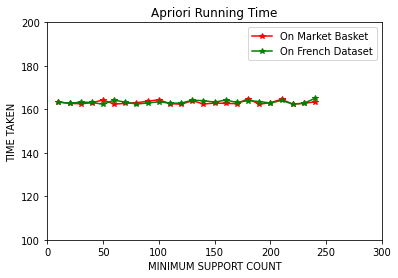

In [20]:
def show_plot(time_list, time_list2):
    X1 = list()
    Y1 = list()
    for item in time_list:
        X1.append(item[0])
        Y1.append(item[1])


    X2 = list()
    Y2 = list()
    for item in time_list2:
        X2.append(item[0])
        Y2.append(item[1])

    
    
    plt.plot(X1,Y1, 'r-*', label = 'On Market Basket')
    plt.plot(X2,Y2, 'g-*', label = 'On French Dataset')
    
    plt.plot()
    plt.xlim(0,300)
    plt.ylim(100,200)
    plt.xlabel('MINIMUM SUPPORT COUNT')
    plt.ylabel('TIME TAKEN')
    plt.legend()
    plt.title(f"Apriori Running Time")
    

show_plot(variable1, variable2)
# plt.plot(variable[1][:], range(10,250,10))